In [1]:
#Import Libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
import pylab
from scipy.stats import shapiro, normaltest, skew, kurtosis
from scipy.stats import chi2_contingency
import itertools

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Import the data
df = pd.read_csv('churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


From the data exploration, I noticed that the value of 'TotalCharges' is object (string) while it's a numerical value and needed to change it to float. However, after trying to replace the value using .astype(float), there was a error message popping up as: ValueError: could not convert string to float: ' '

This suggests that there are virtual null values that are categorized as ' ', blank spaces, in this feature but not showing up in the null value check. Here, I am going to replace the ' ' in 'TotalCharges' with the mean value of the feature while replacing the datatype as float.

In [5]:
# change the data type of MonthlyCharges from string to float
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0).astype(float)
print('dtype of Total Charges is:', df['TotalCharges'].dtype)
# drop CustomerID
df_cleaned = df.drop('customerID', axis=1)
df_cleaned.info()

dtype of Total Charges is: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  Payment

In [14]:
df_cleaned.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [ ]:
# data type successfully got changed to float in the previous section!
# Since the minimum value was 18.25 from the initial exploration, I'm simply going to replce the 0 with the mean value
# 1: Calculate the mean of MonthlyCharges (excluding zeros)
monthly_charges_mean = df_cleaned[df_cleaned['MonthlyCharges'] != 0]['MonthlyCharges'].mean()

# 2: Replace 0s with the mean
df_cleaned['MonthlyCharges'] = df_cleaned['MonthlyCharges'].replace(0, monthly_charges_mean)

In [12]:
#check columns for categorical variables
for col in df_cleaned.select_dtypes(include=['object', 'category']).columns:
    print(f"\nColumn: {col}")
    print(df_cleaned[col].value_counts())


Column: gender
gender
Male      3555
Female    3488
Name: count, dtype: int64

Column: Partner
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Column: Dependents
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

Column: PhoneService
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

Column: MultipleLines
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

Column: InternetService
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

Column: OnlineSecurity
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

Column: OnlineBackup
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

Column: DeviceProtection
DeviceProtection
No                     3095
Yes                    2422
No internet service   

### Exploratory Data Analysis & Data Visualization

Percentage of Churned vs Non-Churned Customers:

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


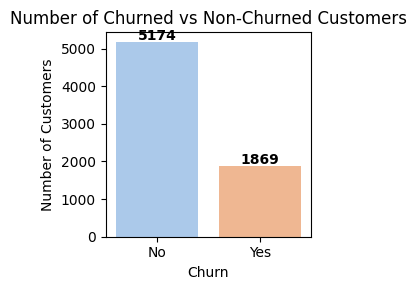

In [78]:
# calculate percentage of churned vs non-churned customers
churn = df_cleaned['Churn']
percent_churn = churn.value_counts(normalize=True) * 100

print("Percentage of Churned vs Non-Churned Customers:\n")
print(percent_churn)

# count churned vs non-churned
churn_counts = df_cleaned['Churn'].value_counts()

# plot
plt.figure(figsize=(3, 3))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='pastel')

# add labels
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.title('Number of Churned vs Non-Churned Customers')
for i, v in enumerate(churn_counts.values):
    plt.text(i, v + max(churn_counts.values) * 0.01, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

In [52]:
#create variable for contiuous values
df_con = df_cleaned[['MonthlyCharges', 'TotalCharges', 'tenure', 'Churn']]

In [54]:
def plot_distributions(data, columns=None, bins=30):
    if columns is None:
        columns = data.select_dtypes(include=[np.number]).columns[:3]
    elif len(columns) != 3:
        raise ValueError("Please provide exactly three numerical columns.")
    
    # Define pastel color palette
    colors = sns.color_palette('pastel', len(columns))

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for i, col in enumerate(columns):
        sns.histplot(data[col].dropna(), bins=bins, kde=True, 
                     ax=axes[i], color=colors[i], edgecolor='black')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

In [46]:
# checking the distribuiton of categorical variables
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

def visualize_category_distribution_by_churn(df, columns, cols_per_row=3):
    n_cols = cols_per_row
    n_rows = math.ceil(len(columns) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        # Compute % distribution of each column value by churn status
        counts = df.groupby(['Churn', col]).size().reset_index(name='count')
        pivot = counts.pivot(index='Churn', columns=col, values='count').fillna(0)
        pivot_percent = pivot.div(pivot.sum(axis=1), axis=0) * 100

        # Plot stacked bar chart
        pivot_percent.plot(kind='bar', stacked=True, ax=axes[i], colormap='Set3')
        axes[i].set_title(f'{col} by Churn', fontsize=12)
        axes[i].set_xlabel('Churn')
        axes[i].set_ylabel('Percentage')
        axes[i].legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[i].tick_params(axis='x', rotation=0)

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

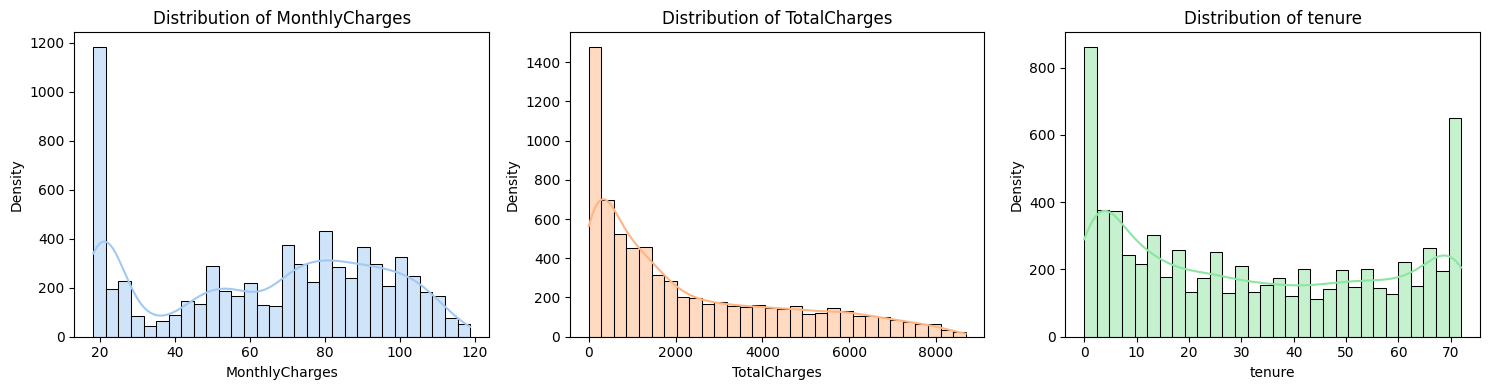

In [56]:
plot_distributions(df_con)

The analyze_continuous_distributions() function creates both density plots and Q-Q plots for all numerical variables in your dataset, allowing you to visually identify normal vs non-normal distributions at a glance.

In [59]:
def analyze_continuous_distributions(df, n_cols=3):
    print("Analyzing distributions of continuous variables...")

    # Select numerical columns
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    if not numerical_cols:
        print("No continuous variables found in the dataset.")
        return
    
    n_vars = len(numerical_cols)
    n_rows = int(np.ceil(n_vars / n_cols))

    # ----- Density Plots -----
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten() if n_vars > 1 else [axes]

    for i, col in enumerate(numerical_cols):
        sns.kdeplot(df[col].dropna(), ax=axes[i], fill=True)
        axes[i].set_title(f'Density Plot of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')

    for j in range(n_vars, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    # ----- Q-Q Plots -----
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten() if n_vars > 1 else [axes]

    for i, col in enumerate(numerical_cols):
        stats.probplot(df[col].dropna(), dist="norm", plot=axes[i])
        axes[i].set_title(f'Q-Q Plot of {col}')

    for j in range(n_vars, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

Analyzing distributions of continuous variables...


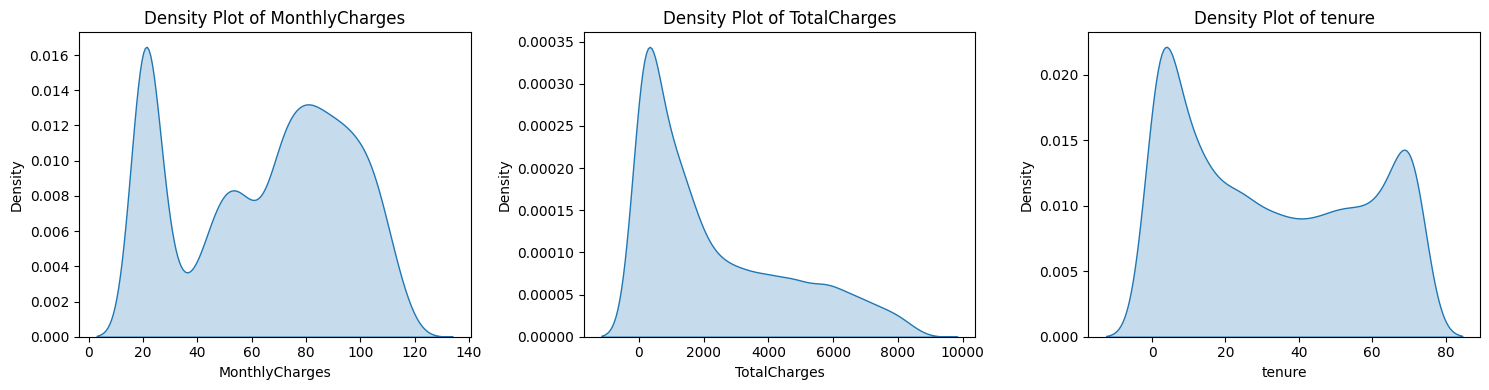

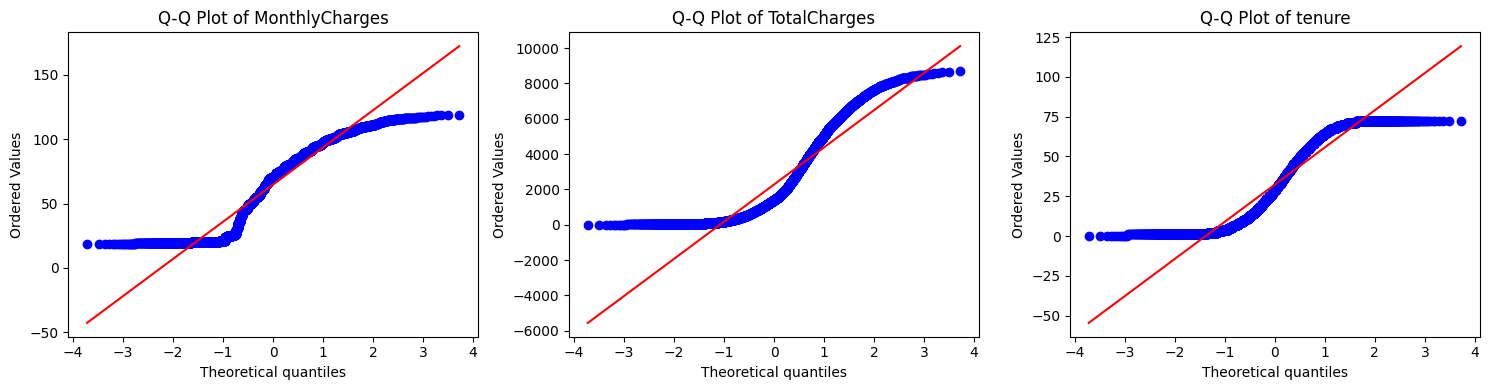

In [61]:
analyze_continuous_distributions(df_con)

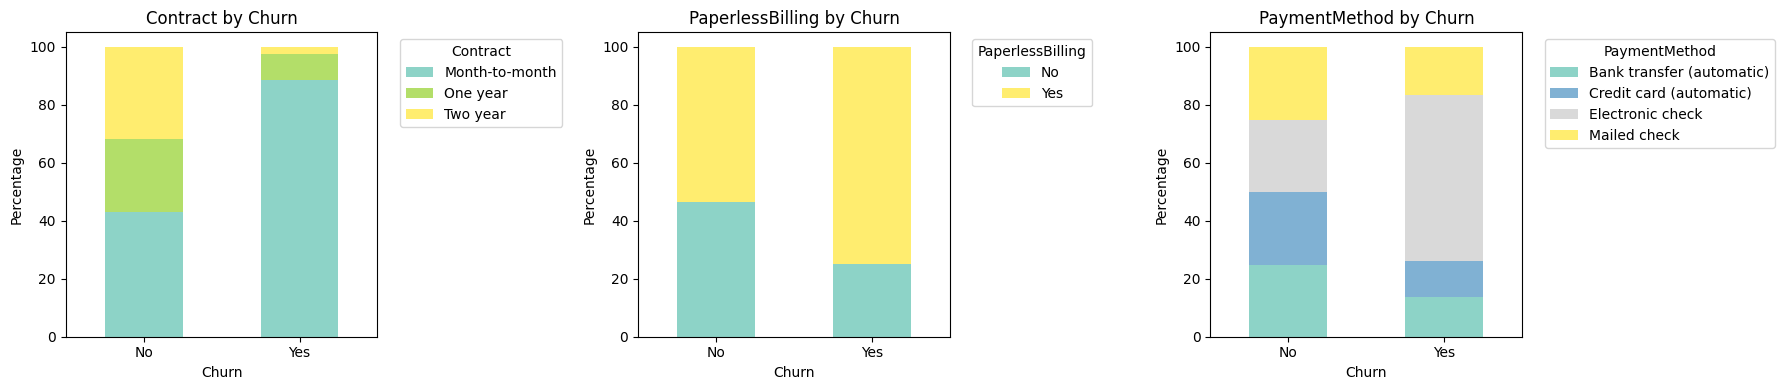

In [48]:
visualize_category_distribution_by_churn(df, ['Contract', 'PaperlessBilling', 'PaymentMethod'])

More Churned customers have month-to-month caontracts > one or two year contracts Churned customers tend to have Paperless billing As a Payment method, Churned have more electronic check > Credit Card, Bank Transfer, and Mailed Check

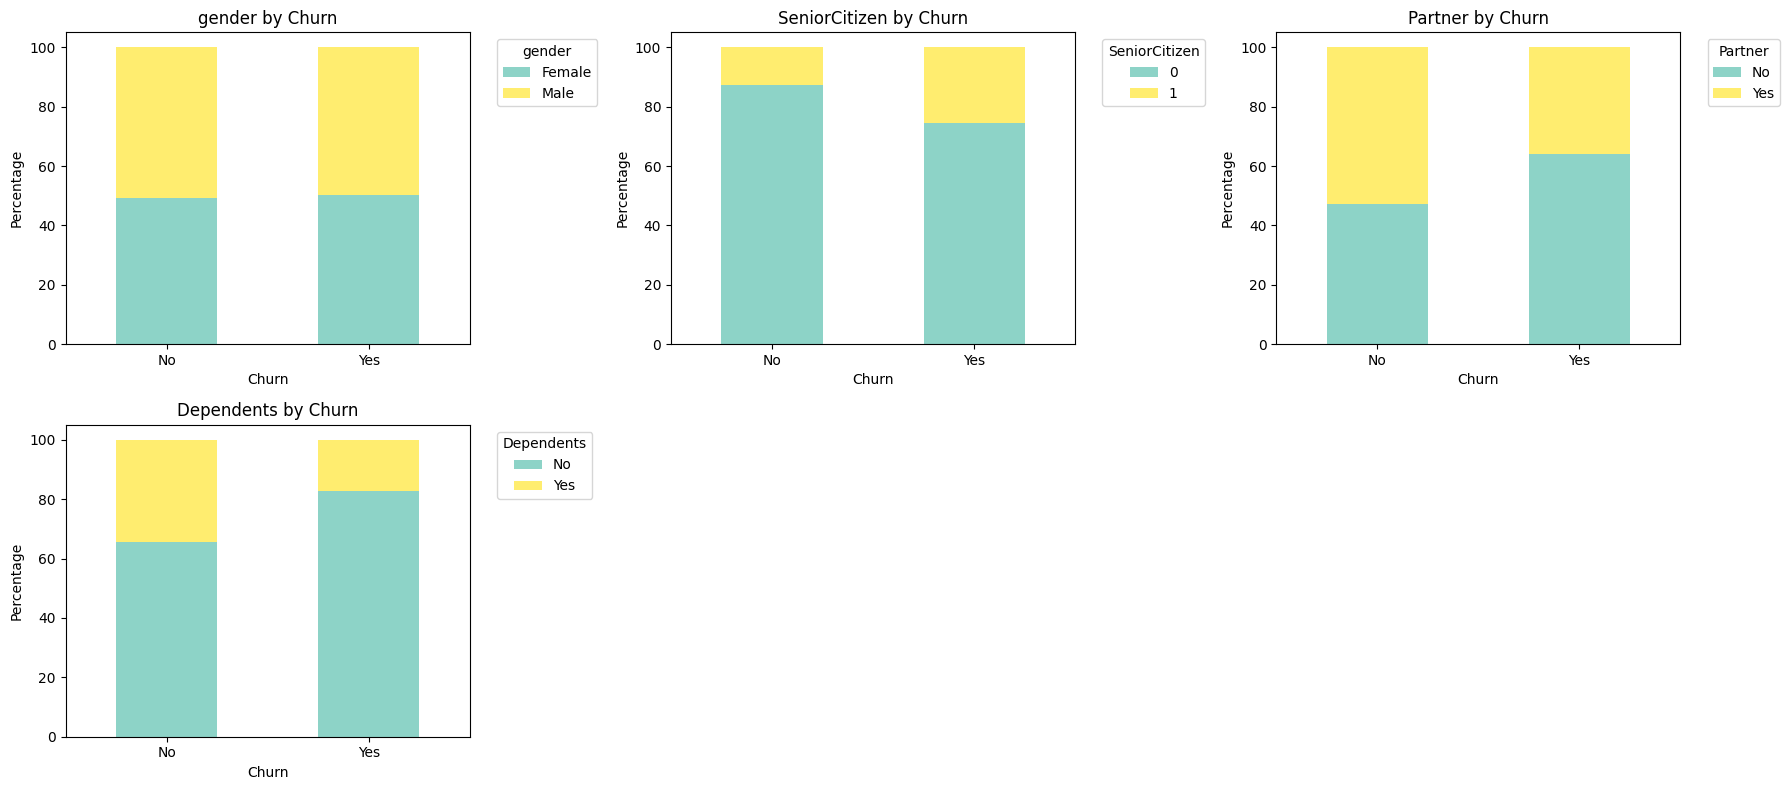

In [41]:
visualize_category_distribution_by_churn(df, ['gender','SeniorCitizen','Partner','Dependents'])

Gender - same
Churned have More Senior citizen, no partner, and no dependents

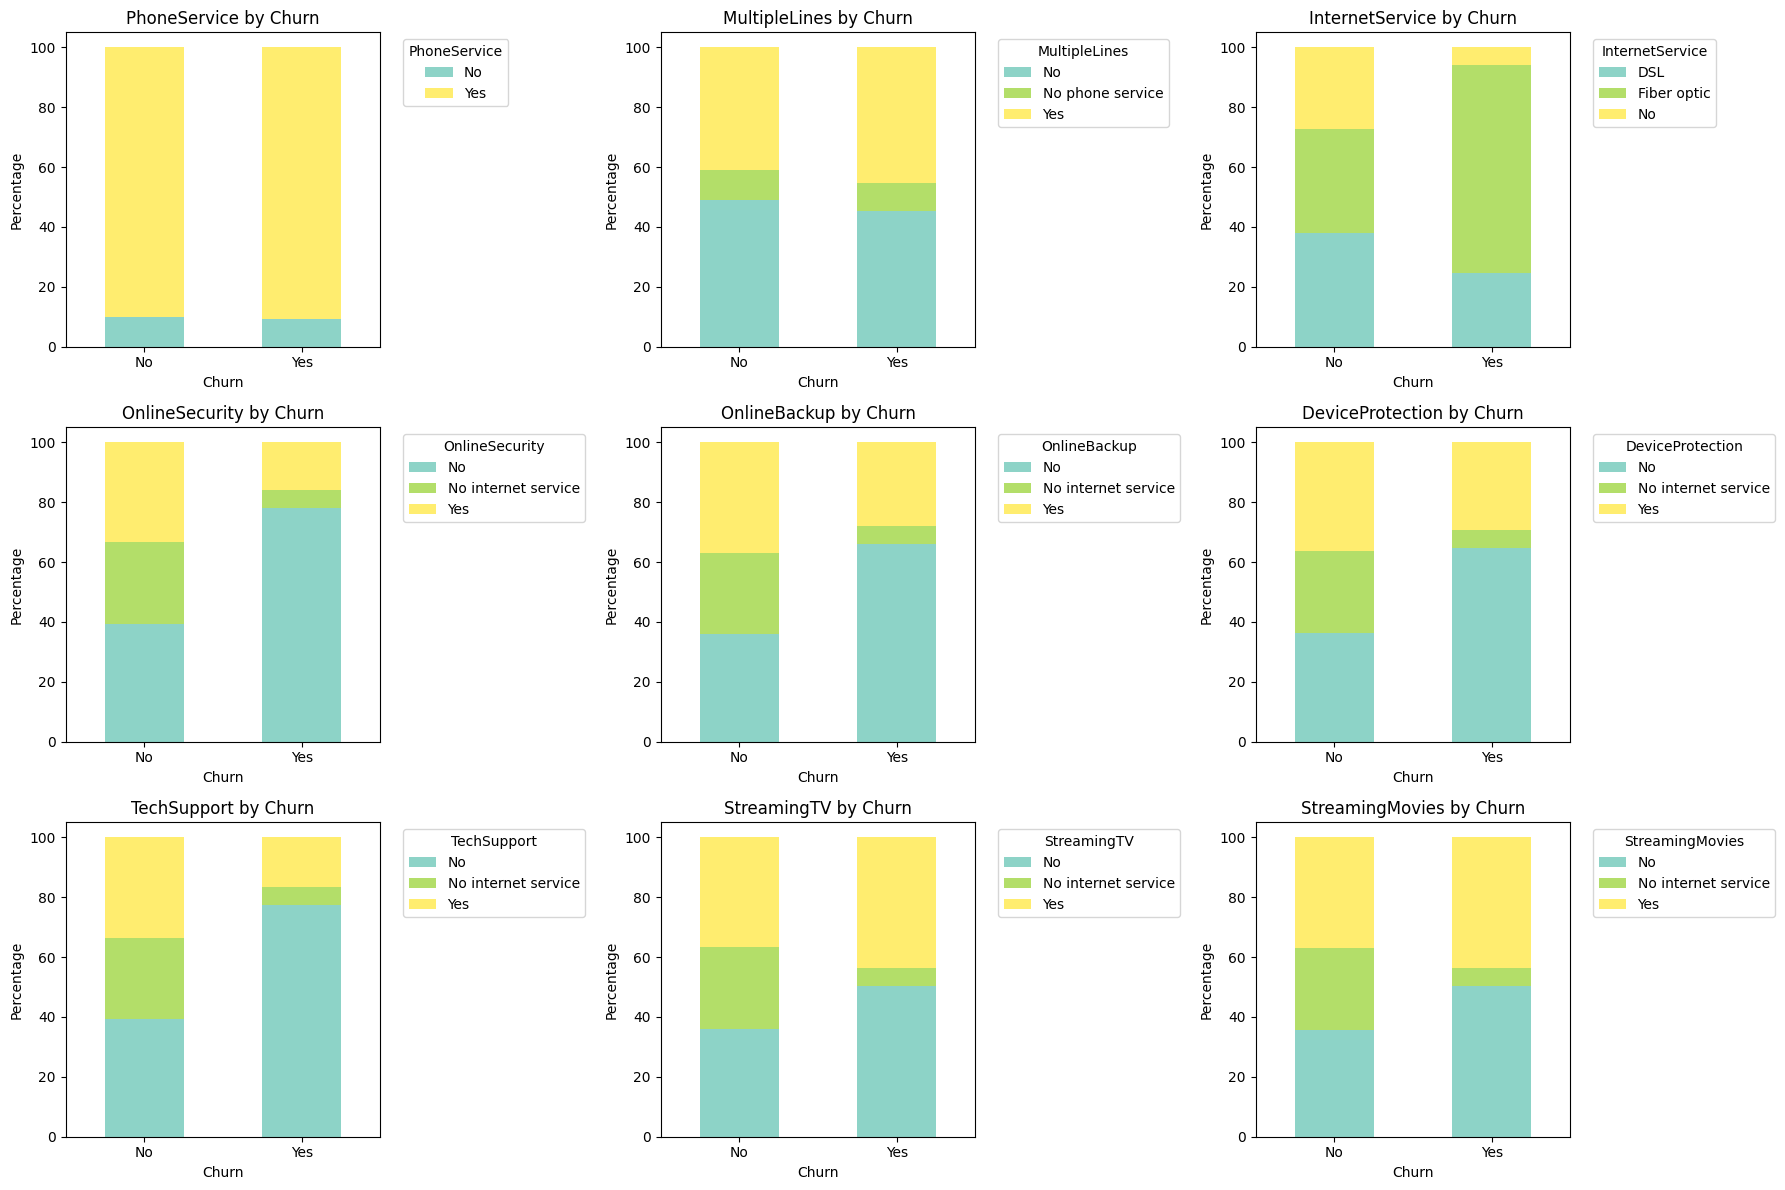

In [44]:
visualize_category_distribution_by_churn(df, ['PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies'])

Phone Service Cateogries, Multiple Lines Categories, - few difference
InternetService Categories - Churned customers have more Fiber Optic
Churned customers tend to have no OnlineSecurity, Online Backup, and Tech Support in Internet Serivce
Churned have less DeviceProtection
Churned have MORE streaming TVs and Movies

In [63]:
#Check the distribution of continuous featrues between Churn vs non-Churned
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_continuous_by_churn(df, columns, plot_type='kde'):
    for col in columns:
        plt.figure(figsize=(4, 3))
        
        if plot_type == 'kde':
            sns.kdeplot(data=df[df['Churn'] == 'No'], x=col, label='Not Churned', fill=True, common_norm=False, alpha=0.5)
            sns.kdeplot(data=df[df['Churn'] == 'Yes'], x=col, label='Churned', fill=True, common_norm=False, alpha=0.5)
        elif plot_type == 'hist':
            sns.histplot(data=df, x=col, hue='Churn', element='step', stat='density', common_norm=False, palette='Set2', alpha=0.5)
        else:
            raise ValueError("plot_type must be 'kde' or 'hist'")

        plt.title(f'Distribution of {col} by Churn')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend(title='Churn')
        plt.tight_layout()
        plt.show()

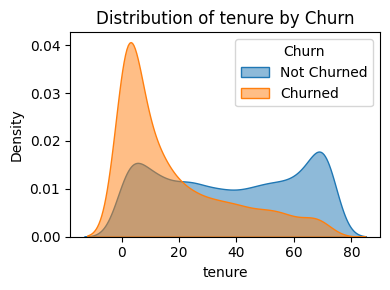

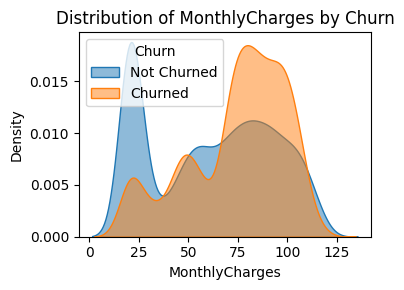

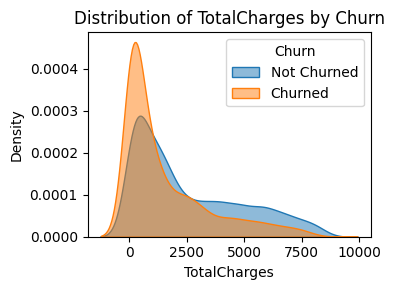

In [65]:
visualize_continuous_by_churn(df_cleaned, ['tenure','MonthlyCharges','TotalCharges'])

Churned customers tend to leave in early phase of tenure and TotalCharges, however, have more MonthlyCharges

In [68]:
# Check the avg value per Churn
def avg_value_by_churn(df, churn_col, cols):
    # Return the result so you can see it
    return df.groupby(churn_col)[cols].mean()

# For column selection, use a list, not df[]
cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
avg_value_by_churn(df, 'Churn', cols)

,tenure,MonthlyCharges,TotalCharges
Churn,,,
No,37.569965,61.265124,2549.911442
Yes,17.979133,74.441332,1531.796094


In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_dist_by_contract_and_churn(df, col):
    """
    Plot distribution of a continuous variable (e.g., tenure) 
    for each Contract type, split by Churn status.
    """
    custom_palette = {'Yes': '#fc8d62', 'No': '#66c2a5'}
    contract_types = ['Month-to-month', 'One year', 'Two year']

    plt.figure(figsize=(15, 4))  # wider to accommodate 3 plots

    for i, contract in enumerate(contract_types, 1):
        plt.subplot(1, 3, i)
        subset = df[df['Contract'] == contract]
        sns.kdeplot(data=subset, x=col, hue='Churn', fill=True, common_norm=False, palette=custom_palette)
        plt.title(f'{col} Distribution: {contract}')
        plt.xlabel(f'{col} (months)')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

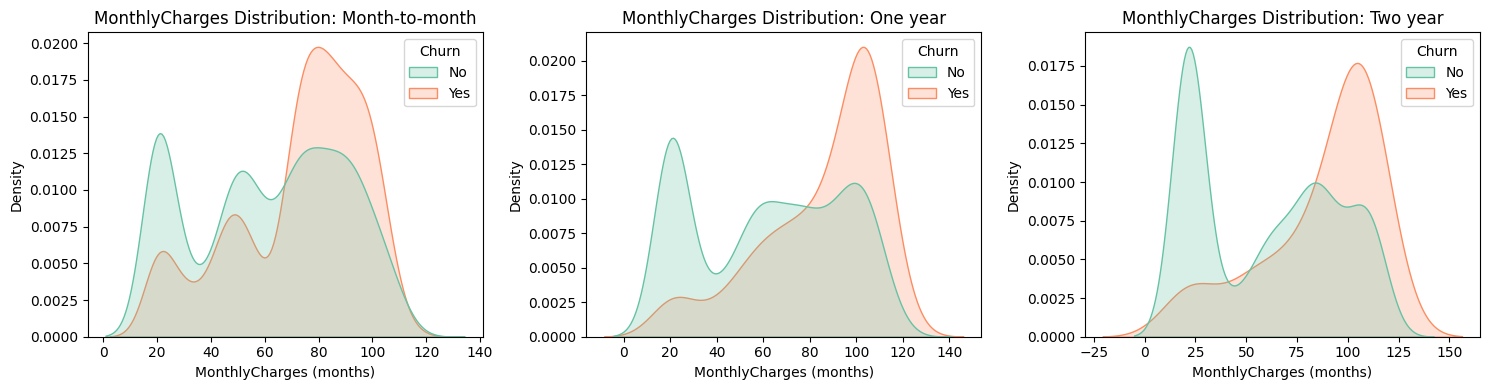

In [73]:
plot_dist_by_contract_and_churn(df, 'MonthlyCharges')

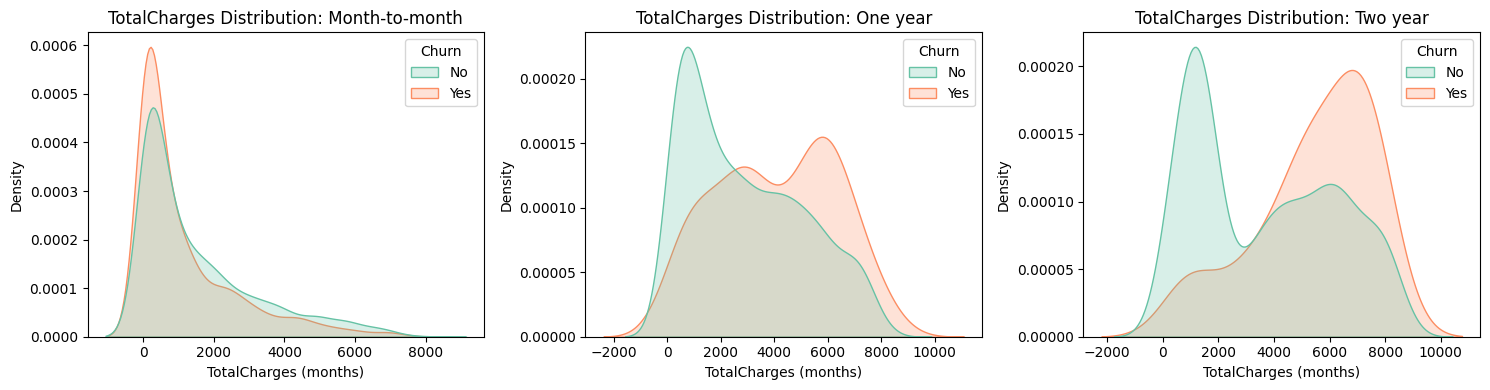

In [75]:
plot_dist_by_contract_and_churn(df, 'TotalCharges')

People with high monthly charge tend to churn in any contract types. Total charges of churned customers in month-to-month contract tend to be lower